In [61]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cma

In [62]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [63]:
frames = []
ss = ['Confirmed', 'Deaths', 'Recovered']
for s in ss:
    frames.append(pd.read_csv(f'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-{s}.csv'))

In [64]:
df = pd.concat(frames,axis=0,keys=ss,names=['Status','Idx']).reset_index(level='Idx', drop=True).reset_index(level='Status')

In [65]:
dfm = df.melt(
    id_vars=['Status','Province/State','Country/Region','Lat','Long'],
    var_name='Date',
    value_name='count'
)
dfm = dfm.rename(columns={'Country/Region':'Country','Province/State':'Province'})
dfm['Date'] = pd.to_datetime(dfm.Date, format='%m/%d/%y')
del(df)

In [66]:
dfm.loc[((dfm['Status'] == 'Confirmed') & (dfm['Country'] == 'Italy') & (dfm['Date'] == '2020-03-12')),'count'] = 15113
dfm.loc[(dfm['Status'] == 'Deaths') & (dfm['Country'] == 'Italy') & (dfm['Date'] == '2020-03-12'), 'count'] = 1016
dfm.loc[(dfm['Status'] == 'Confirmed') & (dfm['Country'] == 'France') & (dfm['Province'] == 'France') & (dfm['Date'] == '2020-03-12'),'count'] = 2876
dfm.loc[(dfm['Status'] == 'Deaths') & (dfm['Country'] == 'France') & (dfm['Province'] == 'France') & (dfm['Date'] == '2020-03-12'),'count'] = 61

In [67]:
dfm_country = dfm.groupby(['Country','Status','Date'])['count'].sum().reset_index('Status')
dfm_country.head(2)

Status  count
Country     Date                        
Afghanistan 2020-01-22  Confirmed      0
            2020-01-23  Confirmed      0

In [68]:
dfm_country_piv = dfm_country.pivot(columns='Status').sort_values('Date')
dfm_country_piv.columns = dfm_country_piv.columns.droplevel(level=0)
dfm_country_piv.head(2)

,Status,Confirmed,Deaths,Recovered
Country,Date,,,
Afghanistan,2020-01-22,0,0,0
Egypt,2020-01-22,0,0,0


<IPython.core.display.Javascript object>


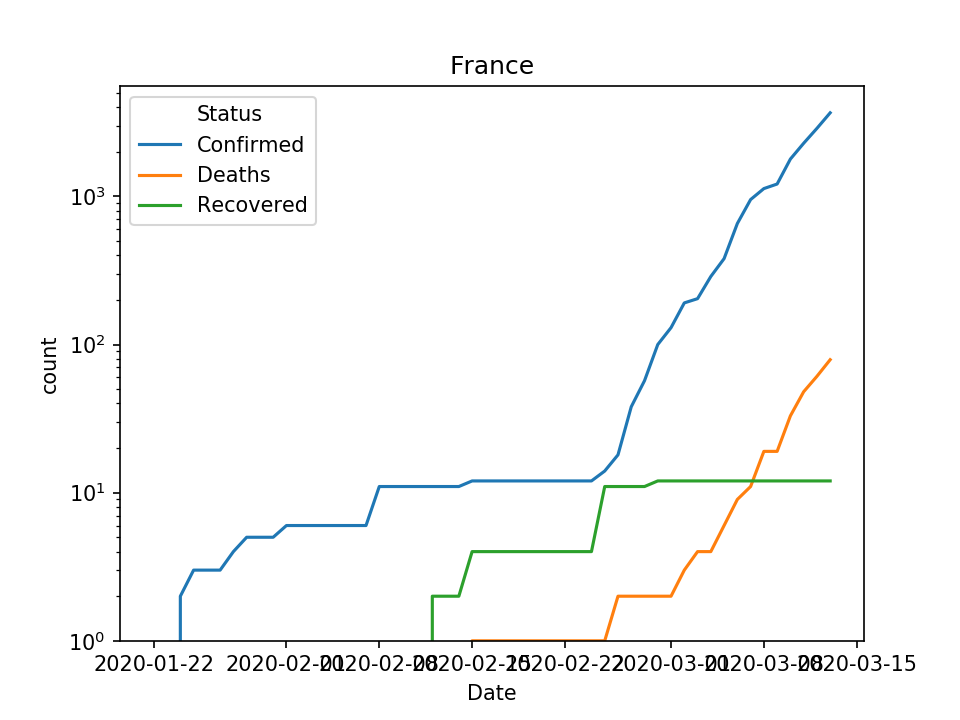

<IPython.core.display.Javascript object>


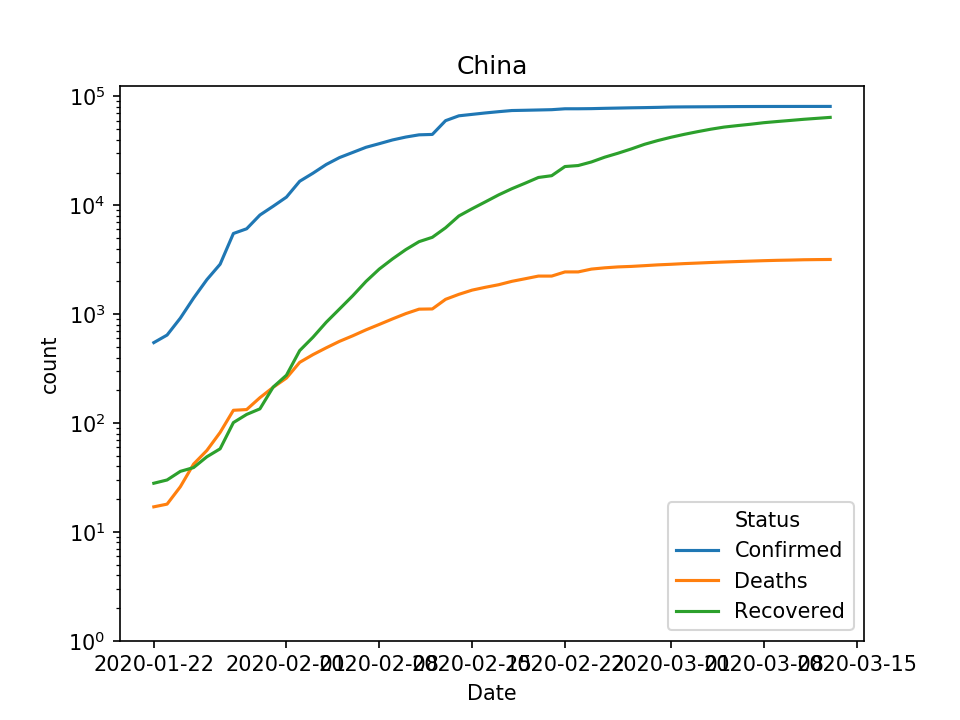

<IPython.core.display.Javascript object>


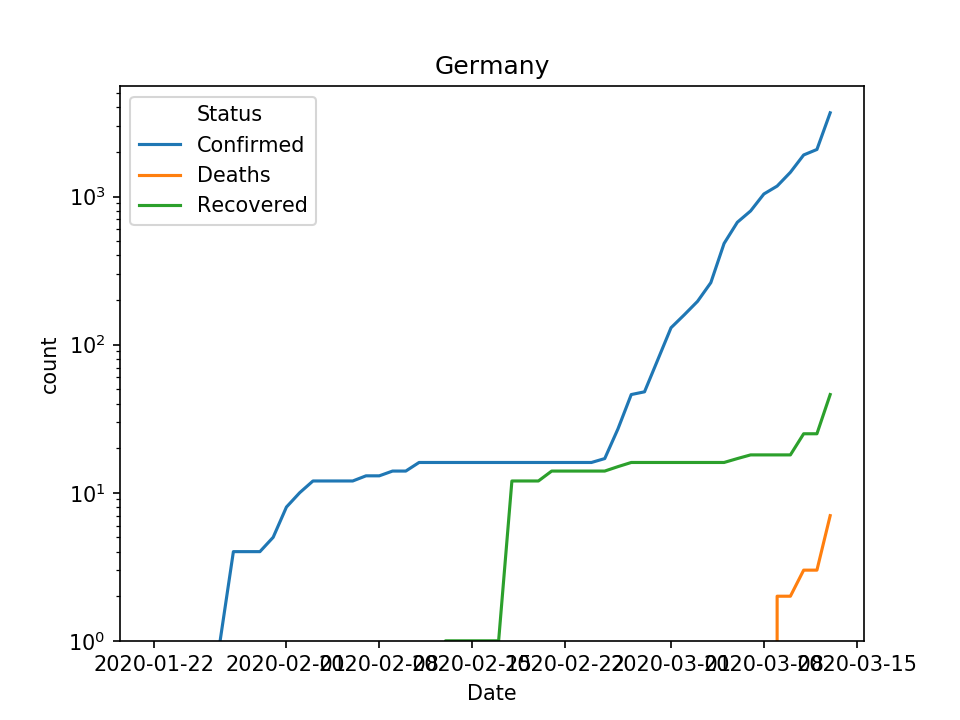

<IPython.core.display.Javascript object>


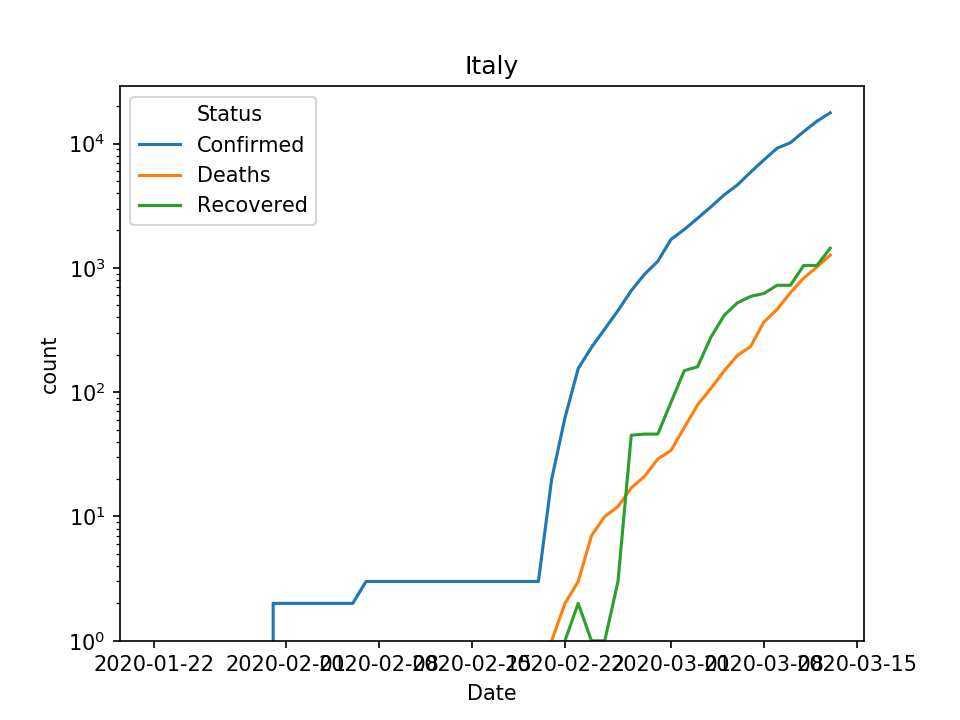

In [71]:
for cntry in ['France', 'China', 'Germany', 'Italy']:
    plt.figure()
    sns.lineplot(data=dfm_country.reset_index().query(f'Country == "{cntry}"'),x='Date',y='count',hue='Status')
    plt.yscale('log')
    _, ylimh = plt.ylim()
    plt.ylim(1,ylimh)
    plt.title(cntry)

<IPython.core.display.Javascript object>


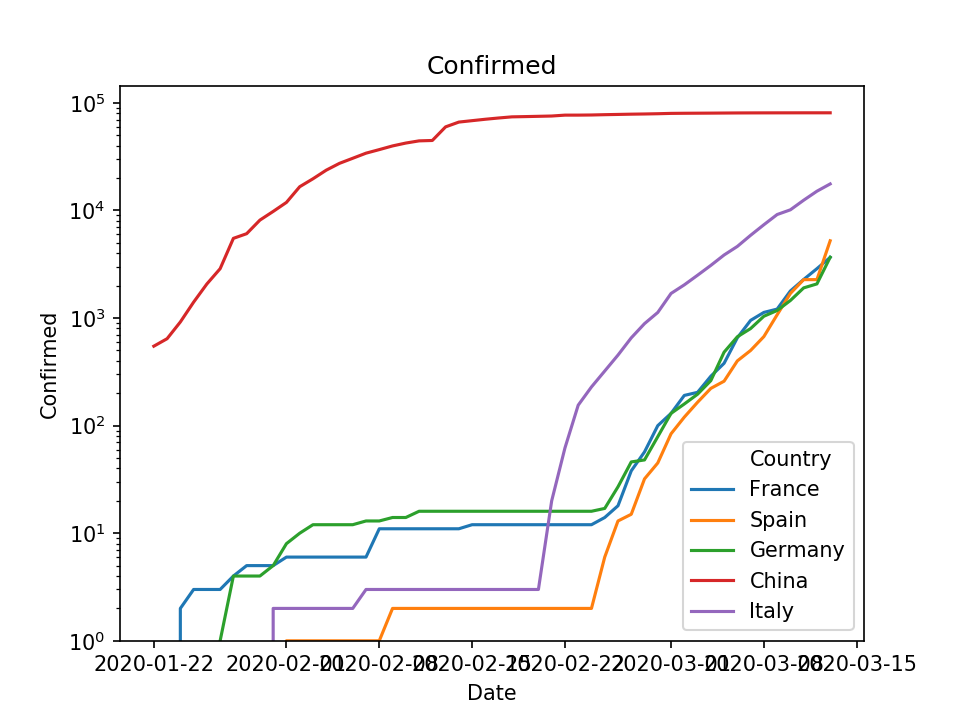

<IPython.core.display.Javascript object>


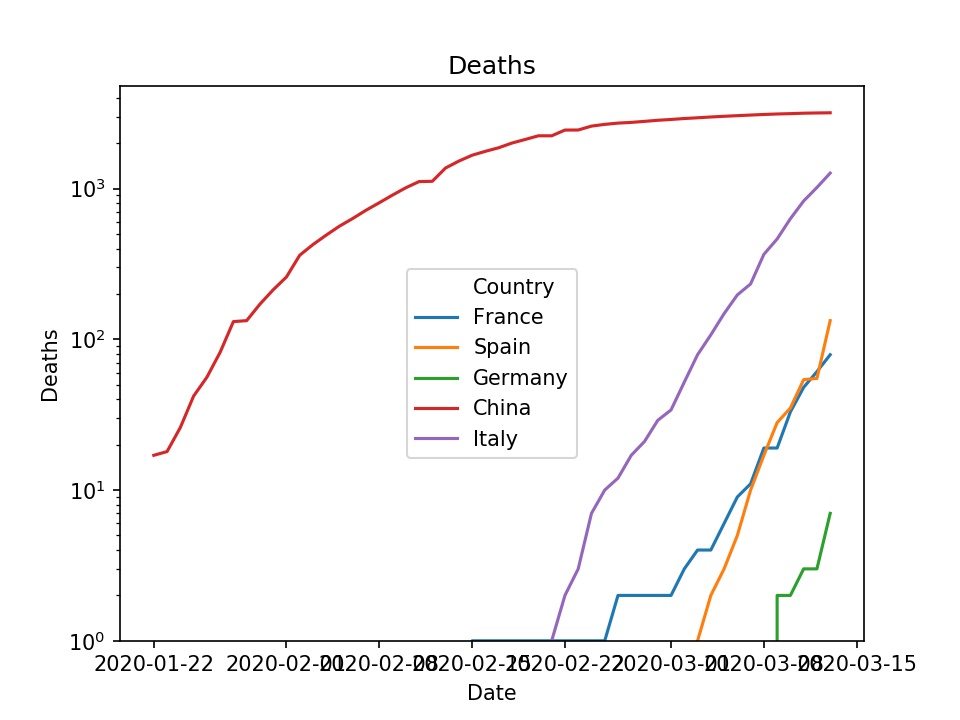

<IPython.core.display.Javascript object>


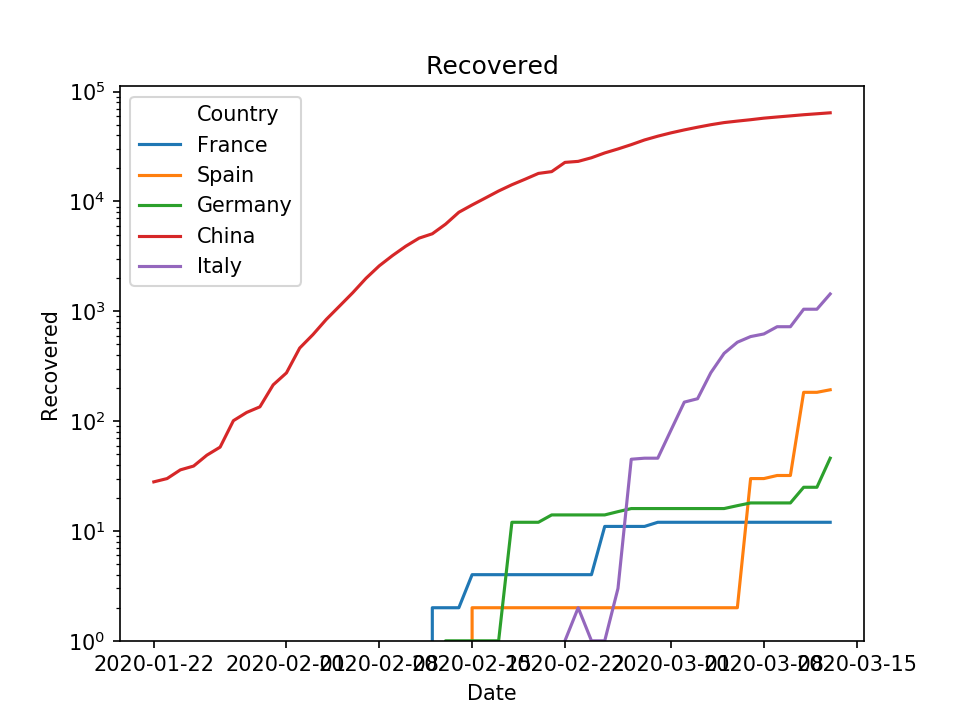

In [72]:
cntries = ['France', 'China', 'Germany', 'Italy', 'Spain']
for status in dfm_country_piv.columns:
    plt.figure()
    sns.lineplot(data=dfm_country_piv.loc[cntries].reset_index(),x='Date',y=status,hue='Country')
    plt.yscale('log')
    _, ylimh = plt.ylim()
    plt.ylim(1,ylimh)
    plt.title(status)

In [11]:
def relative_growth(subdf):
    return 1 + subdf.diff() / subdf

In [12]:
relgrowth = dfm_country_piv.groupby(level=0).apply(relative_growth).dropna()

In [13]:
deathrate = dfm_country_piv['Deaths'] / dfm_country_piv['Confirmed'] 

In [52]:
frconf = dfm_country_piv.loc['Italy'].loc['2020-02-25':]['Deaths']
def score(x):
    n0, r = x
    simu = n0*np.exp(r*np.arange(frconf.shape[0]))
    return np.sum((simu-frconf.to_numpy())**2)

In [53]:
es = cma.CMAEvolutionStrategy(np.array([14,1/100]),1,{'bounds':([1,0],[None,np.log(10)])})
es.optimize(score)
n0best, rbest = es.best.x

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=343909, Sat Mar 14 16:49:51 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 4.041027155624206e+06 1.0e+00 9.86e-01  8e-01  1e+00 0:00.0
    2     12 4.069400521998318e+06 1.4e+00 7.94e-01  5e-01  9e-01 0:00.0
    3     18 6.589395887250253e+06 1.7e+00 7.81e-01  5e-01  8e-01 0:00.0
  100    600 9.839275568846573e+03 2.8e+03 8.29e-05  9e-09  2e-06 0:00.2
  200   1200 9.839275568846073e+03 1.6e+03 1.79e-06  2e-12  4e-10 0:00.4
  242   1452 9.839275568846117e+03 3.1e+03 2.46e-07  5e-14  1e-11 0:00.4


<IPython.core.display.Javascript object>


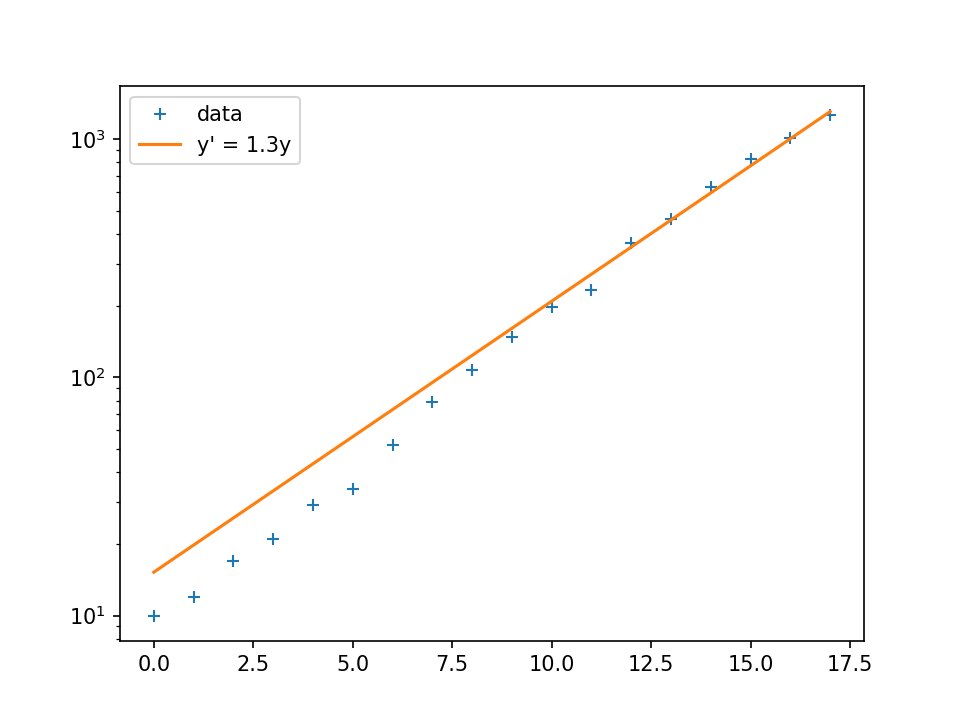

In [54]:
plt.figure()
plt.plot(frconf.to_numpy(),'+',label='data')
plt.plot(n0best*np.exp(rbest*np.arange(frconf.shape[0])),label=f'y\' = {np.exp(es.best.x[1]):.3}y')
plt.legend()
plt.yscale('log')

In [17]:
n

1.361074327471434

In [18]:
N = 10
startdate = '2020-03-13'
pd.Series(dfm_country_piv.loc['France'].loc[startdate]['Deaths']*np.exp(es.best.x[1]*np.arange(N)),
          index=pd.date_range(start=startdate,periods=N)).astype(np.int)

2020-03-13      79
2020-03-14     107
2020-03-15     146
2020-03-16     199
2020-03-17     271
2020-03-18     369
2020-03-19     502
2020-03-20     683
2020-03-21     930
2020-03-22    1266
Freq: D, dtype: int64

In [19]:
np.log(2)/es.best.x[1]

2.248475149631648

<IPython.core.display.Javascript object>


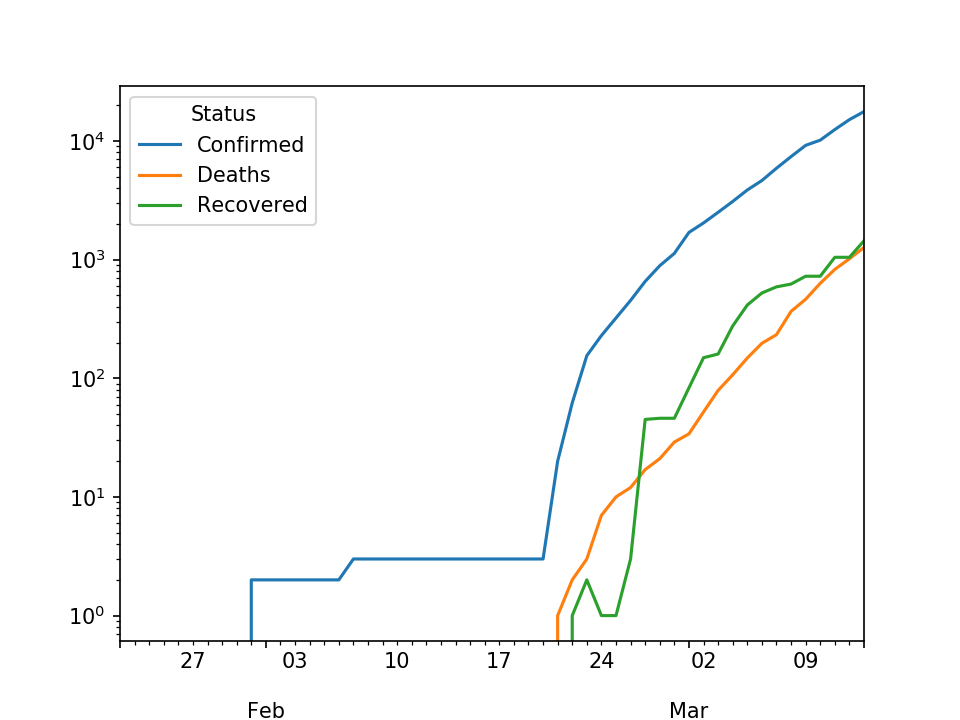

In [22]:
dfm_country_piv.loc['Italy'].plot()
plt.yscale('log')

In [21]:
relgrowth.loc['Italy']

Status,Confirmed,Deaths,Recovered
Date,,,
2020-02-22,1.677419,1.500000,2.000000
2020-02-23,1.600000,1.333333,1.500000
2020-02-24,1.323144,1.571429,0.000000
2020-02-25,1.288820,1.300000,1.000000
2020-02-26,1.289183,1.166667,1.666667
2020-02-27,1.308397,1.294118,1.933333
2020-02-28,1.262387,1.190476,1.021739
2020-02-29,1.212766,1.275862,1.000000
2020-03-01,1.334120,1.147059,1.445783


In [59]:
dfm[(dfm['Province'] == 'Hubei') & (dfm['Date'] == '2020-03-13')]

,Status,Province,Country,Lat,Long,Date,count
64569,Confirmed,Hubei,China,30.9756,112.2707,2020-03-13,67786
64990,Deaths,Hubei,China,30.9756,112.2707,2020-03-13,3062
65411,Recovered,Hubei,China,30.9756,112.2707,2020-03-13,51553


In [60]:
dfm_country_piv.loc['China'].loc['2020-03-13']

Status
Confirmed    80945
Deaths        3180
Recovered    64196
Name: 2020-03-13 00:00:00, dtype: int64